In [702]:
import os
import json
import time
import imageio
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import itertools
import networkx as nx
from selenium import webdriver
from datetime import datetime
from folium.features import DivIcon
from pprint import pprint as pp
import branca.colormap as cm
from networkx.algorithms.community import girvan_newman, modularity
from networkx.algorithms import degree_centrality
from networkx.algorithms import eigenvector_centrality
from networkx.algorithms import betweenness_centrality

In [703]:
# Reading CSV file of flight records and geographical data of Brazilian airports.
airport_column = [
    'ICAO_code', 'IATA_code', 'airport_name', 'city/town', 'country',
    'latitude_degrees', 'latitude_minutes', 'latitude_seconds',
    'latitude_direction', 'longitude_degrees', 'longitude_minutes',
    'longitude_seconds', 'longitude_direction', 'altitude',
    'latitude_decimal_degrees', 'longitude_decimal_degrees'
]
df_airports = pd.read_csv('GlobalAirportDatabase.txt',
                          sep=':',
                          names=airport_column)
df_flights = pd.read_csv('raw_2021.csv', low_memory=False)

In [704]:
# Keeping flights with 'realized' situation.
df_flights = df_flights[df_flights['situation'] == "REALIZADO"][[
    'company', 'flight', 'line_type', 'origin', 'destination', 'real_arr',
    'situation'
]]

# Removing rows containing missing values.
df_flights = df_flights.dropna(axis=0, how='all')

# Taking yyyy/mm/dd as date format.
df_flights.rename(columns={'real_arr': 'arrive_date'}, inplace=True)
df_flights['arrive_date'] = [
    str(i).split(' ')[0] for i in df_flights['arrive_date']
]
df_flights['month'] = pd.to_datetime(
    df_flights['arrive_date']).dt.strftime("%Y.%m")
df_flights['arrive_date'] = pd.to_datetime(df_flights['arrive_date'],
                                           format="%Y-%m-%d %H:%M:%S")

# Appending longitude and latitude of airports by merging two dataframes.
df_airports_location = df_airports[[
    'ICAO_code', 'country', 'latitude_decimal_degrees',
    'longitude_decimal_degrees'
]]

df_airports_location.columns = [
    'origin', 'origin_country', 'origin_latitude', 'origin_longitude'
]
df_flights = pd.merge(df_flights,
                      df_airports_location,
                      on='origin',
                      how='left')

df_airports_location.columns = [
    'destination', 'destination_country', 'destination_latitude',
    'destination_longitude'
]
df_flights = pd.merge(df_flights,
                      df_airports_location,
                      on='destination',
                      how='left')

# Dropping flights without longitude or latitude or flights where
# origin and destination are at the same place.
df_flights.replace(0, np.NaN)
df_flights = df_flights.drop(
    df_flights[df_flights['origin'] == df_flights['destination']].index)
df_flights = df_flights.dropna()

# Keeping domestic flights only.
df_flights = df_flights[df_flights['line_type'] == "N"]

# Setting arrival date as index.
df_flights = df_flights.set_index('arrive_date', drop=False)

df_flights.head()

,company,flight,line_type,origin,destination,arrive_date,situation,month,origin_country,origin_latitude,origin_longitude,destination_country,destination_latitude,destination_longitude
arrive_date,,,,,,,,,,,,,,
2019-06-07,AZU,2497,N,SBMO,SBRF,2019-06-07,REALIZADO,2019.06,BRAZIL,-9.510,-35.793,BRAZIL,-8.126,-34.923
2019-06-07,AZU,2493,N,SBMK,SBCF,2019-06-07,REALIZADO,2019.06,BRAZIL,-16.707,-43.819,BRAZIL,-19.634,-43.969
2019-06-07,AZU,2489,N,SBRF,SBGR,2019-06-07,REALIZADO,2019.06,BRAZIL,-8.126,-34.923,BRAZIL,-23.432,-46.469
2019-06-07,AZU,2488,N,SBGR,SBRF,2019-06-07,REALIZADO,2019.06,BRAZIL,-23.432,-46.469,BRAZIL,-8.126,-34.923
2019-06-07,AZU,2487,N,SBFL,SBKP,2019-06-07,REALIZADO,2019.06,BRAZIL,-27.672,-48.548,BRAZIL,-23.008,-47.134


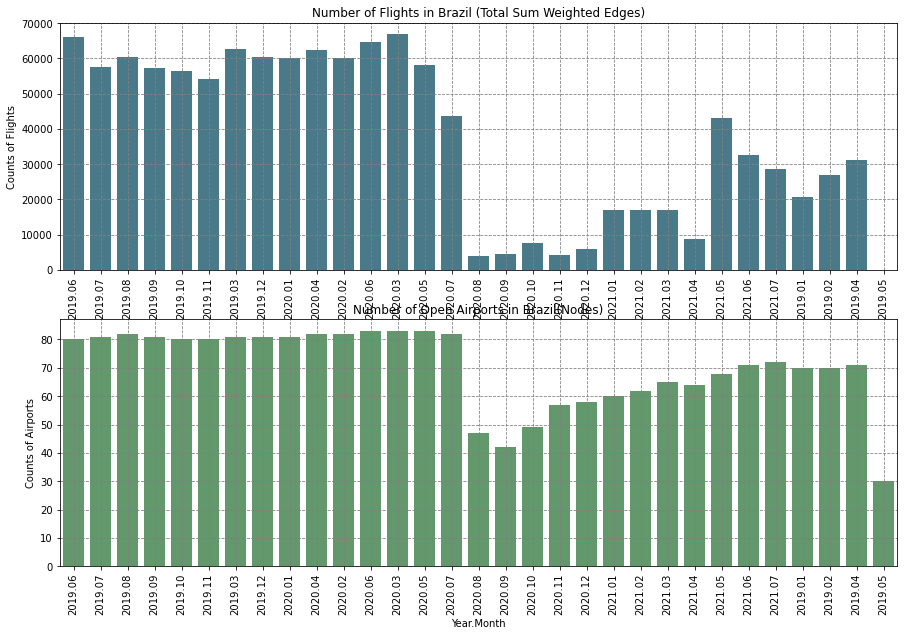

In [289]:
monthly_data = pd.DataFrame(
    columns=['month', 'monthly_flight_count', 'monthly_airport_count'])
monthly_data['month'] = [i for i in df_flights['month'].unique()]
monthly_data['monthly_flight_count'] = [
    i for i in df_flights.groupby('month')['situation'].count()
]

monthly_airport = pd.concat([
    df_flights[[
        'month',
        'origin',
    ]].rename(columns={'origin': 'airport'}), df_flights[[
        'month', 'destination'
    ]].rename(columns={'destination': 'airport'})
],
                            axis=0).drop_duplicates()
monthly_data['monthly_airport_count'] = [
    i for i in monthly_airport.groupby('month')['airport'].count()
]

# Ploting barplot of month flight counts.
fig=plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
sns.barplot(x=monthly_data['month'],
            y=monthly_data['monthly_flight_count'],
            data=monthly_data,
            color='#3f7f93')
# Adding labels
ax1.set_title('Number of Flights in Brazil (Total Sum Weighted Edges)')
ax1.set_xlabel('Year.Month')
ax1.set_ylabel('Counts of Flights')
plt.grid(color='grey', ls='--')
plt.xticks(rotation=90)

ax2 = fig.add_subplot(212)
sns.barplot(x=monthly_data['month'],
            y=monthly_data['monthly_airport_count'],
            data=monthly_data,
            color='#59a165')
# Adding labels
ax2.set_title('Number of Open Airports in Brazil(Nodes)')
ax2.set_xlabel('Year.Month')
ax2.set_ylabel('Counts of Airports')
plt.grid(color='grey', ls='--')
plt.xticks(rotation=90)

plt.show()

In [789]:
class flight_network:
    def __init__(self, dataset, begin_date, end_date):
        self.dataset = dataset
        self.begin_date = begin_date
        self.end_date = end_date

    def date_string(self):

        date_string = [
            str(i).split(' ')[0]
            for i in self.dataset.index.unique().sort_values(ascending=True)
            if str(i).split(' ')[0] >= self.begin_date
            and str(i).split(' ')[0] <= self.end_date
        ]
        return date_string

    def flight_frequency(self):

        date_string = self.date_string()
        dataset = self.dataset
        # Due to unavailability of data or extreme cases of complete flight vacuum in
        # specific days, we only consider data that consists of at least one flight per day.
        if len(dataset[dataset.index.isin(date_string)].iloc[:, 0]) > 0:
            dt = dataset.loc[(dataset.index >= self.begin_date)
                             & (dataset.index <= self.end_date)]

            # Zipping the longitude and latitude coordination of origins in the list
            origin_coordinate = list(
                zip(dt['origin'], dt['origin_latitude'],
                    dt['origin_longitude']))
            origin_coordinate = [[i[0], i[1], i[2]] for i in origin_coordinate]

            # Zipping the longitude and latitude coordination of destinations in the list
            destination_coordinate = list(
                zip(dt['destination'], dt['destination_latitude'],
                    dt['destination_longitude']))
            destination_coordinate = [[i[0], i[1], i[2]]
                                      for i in destination_coordinate]

            # Forming complete flight geological geographical information by zipping coordinations
            # of origin and destination.
            ori_des_coordinate = list(
                zip(origin_coordinate, destination_coordinate))
            ori_des_coordinate = [[i[0], i[1]] for i in ori_des_coordinate]

            # Since we have simplified the flight model as an undirected network, we view round-trip flights
            # are symmetric, even though there are still some evidence of asymmetry in flight numbers between
            # certain cities. We need to exchange coordinations of origin and destination if an exact opposite
            # pair of origin and destination coordinates is found in the list ori_des_co, in order to calculate
            # the weight, namely the frequency between two cities regardless their direction.
            for i in ori_des_coordinate:
                a = i[0][0]
                b = i[1][0]
                for j in range(len(ori_des_coordinate)):
                    xa = ori_des_coordinate[j][0][0]
                    xb = ori_des_coordinate[j][1][0]
                    ya = ori_des_coordinate[j][0]
                    yb = ori_des_coordinate[j][1]
                    if xa == b and xb == a:
                        ori_des_coordinate[j][0] = yb
                        ori_des_coordinate[j][1] = ya

            # Now we drop the duplicates in same flight and calculate number of orrurence of each flight as frequency.
            ori_des_coordinate_unique = []
            for i in ori_des_coordinate:
                if i not in ori_des_coordinate_unique:
                    ori_des_coordinate_unique.append(i)

            weight = []
            for i in ori_des_coordinate_unique:
                weight.append(ori_des_coordinate.count(i))

            flight_frequency = pd.DataFrame(columns=[
                'origin', 'origin_coordinate', 'destination',
                'destination_coordinate', 'weight'
            ])
            flight_frequency['origin'] = [
                i[0][0] for i in ori_des_coordinate_unique
            ]
            flight_frequency['origin_coordinate'] = [
                [i[0][1], i[0][2]] for i in ori_des_coordinate_unique
            ]
            flight_frequency['destination'] = [
                i[1][0] for i in ori_des_coordinate_unique
            ]
            flight_frequency['destination_coordinate'] = [
                [i[1][1], i[1][2]] for i in ori_des_coordinate_unique
            ]
            flight_frequency['weight'] = weight
        return flight_frequency

    def graph(self):

        flight_frequency = self.flight_frequency()

        nodes = pd.concat(
            [flight_frequency['origin'], flight_frequency['destination']],
            axis=0).drop_duplicates()
        weighted_edges = [
            flight_frequency[['origin', 'destination',
                              'weight']].iloc[i].to_list()
            for i in range(len(flight_frequency['origin']))
        ]
        G = nx.Graph()
        G.add_nodes_from(nodes)
        G.add_weighted_edges_from(weighted_edges)
        return G

    def daily_airport_distribution(self):

        dataset = self.dataset
        # Taking both origin airports and destination airports as daily active airports.
        # Concatenating dataframes vertically then dropping the duplicated rows.
        df_airport_daily = pd.concat([
            dataset[['origin', 'origin_latitude', 'origin_longitude'
                     ]][dataset.index == self.begin_date].rename(
                         columns={
                             'origin': 'airport',
                             'origin_latitude': 'latitude',
                             'origin_longitude': 'longitude'
                         }), dataset[[
                             'destination', 'destination_latitude',
                             'destination_longitude'
                         ]][dataset.index == self.begin_date].rename(
                             columns={
                                 'destination': 'airport',
                                 'destination_latitude': 'latitude',
                                 'destination_longitude': 'longitude'
                             })
        ],
                                     axis=0).drop_duplicates()

        # Setting Folium figures.
        Figure = folium.Figure(width=1000, height=1000)
        Map = folium.Map(location=[-20, -50], zoom_start=5,
                         control_scale=True).add_to(Figure)
        Map.add_child(folium.LatLngPopup())

        # Labelling date.
        folium.Marker(
            location=[-25, -40],
            icon=DivIcon(
                icon_size=(250, 36),
                icon_anchor=(70, -30),
                html='<div style="font-size: 20pt">Date: {}</div>'.format(
                    self.begin_date))).add_to(Map)

        # Plotting airport as nodes.
        for i in range(len(df_airport_daily['airport'])):
            folium.Marker(location=[
                df_airport_daily['latitude'].iloc[i],
                df_airport_daily['longitude'].iloc[i]
            ],
                          icon=folium.Icon(color='black',
                                           icon_color='cadetblue',
                                           icon='plane',
                                           shadowSize=[0, 0],
                                           angle=90,
                                           prefix='glyphicon')).add_to(Map)
        return Map

    def daily_flight_network(self):

        flight_frequency = self.flight_frequency()

        Figure = folium.Figure(width=1000, height=1000)
        Map = folium.Map(location=[-20, -50], zoom_start=5,
                         control_scale=True).add_to(Figure)
        folium.Marker(
            location=[-25, -40],
            icon=DivIcon(
                icon_size=(250, 36),
                icon_anchor=(70, -30),
                html='<div style="font-size: 20pt">Date: {}</div>'.format(
                    self.begin_date))).add_to(Map)

        colormap = cm.LinearColormap(colors=['coral', 'darkred'],
                                     index=[
                                         flight_frequency['weight'].min(),
                                         flight_frequency['weight'].max()
                                     ],
                                     vmin=flight_frequency['weight'].min(),
                                     vmax=flight_frequency['weight'].max())

        for i in range(len(flight_frequency['origin_coordinate'])):
            folium.PolyLine(locations=[
                flight_frequency['origin_coordinate'][i],
                flight_frequency['destination_coordinate'][i]
            ],
                            color=colormap(flight_frequency['weight'][i]),
                            popup='Daily frequency:{}'.format(
                                flight_frequency['weight'][i]),
                            weight=2,
                            opacity=0.5,
                            dash_array=1,
                            smooth_factor=10).add_to(Map)
        return Map

    def dynamic_network_generator(self, function):
        # Saving daily pictures to create a GIF picture.

        # The generator function can create a dynamic picture in any specific periods given
        # start date and end date. The defaulf start date is 2019-01-01 and end date is 2021-07-01.
        date_string = self.date_string()

        # Folium returns a html-based map, so we are going to screenshot it
        # with selenium and save it in png format.
        if function == flight_network.daily_flight_network:
            for date in date_string:
                self.begin_date = date
                Map = self.daily_flight_network()
                MapFname = "flight_network_{}.html".format(date)
                Map.save(MapFname)
                MapUrl = 'file://{0}/{1}'.format(os.getcwd(), MapFname)
                driver = webdriver.Chrome()
                driver.get(MapUrl)
                time.sleep(3)
                driver.save_screenshot('flight_network_{}.png'.format(date))
                driver.quit()

            # Getting all png documents in this folder.
            file_list = os.listdir('.')
            png_list = [
                i for i in file_list
                if i.startswith('flight_network') and i.endswith('.png')
            ]

            # Creating the GIF picture in the chronological order.
            with imageio.get_writer('flight_network_trend.gif',
                                    mode='I',
                                    fps=2) as writer:
                for i in png_list:
                    writer.append_data(imageio.imread(i))

        elif function == flight_network.daily_airport_distribution:
            for date in date_string:
                self.begin_date = date
                Map = self.daily_airport_distribution()
                MapFname = "airport_distribution_{}.html".format(date)
                Map.save(MapFname)
                MapUrl = 'file://{0}/{1}'.format(os.getcwd(), MapFname)
                driver = webdriver.Chrome()
                driver.get(MapUrl)
                time.sleep(3)
                driver.save_screenshot(
                    'airport_distribution_{}.png'.format(date))
                driver.quit()

            file_list = os.listdir('.')
            png_list = [
                i for i in file_list
                if i.startswith('airport_distribution') and i.endswith('.png')
            ]

            # Creating the GIF picture in the chronological order.
            with imageio.get_writer('airport_distribution_trend.gif',
                                    mode='I',
                                    fps=2) as writer:
                for i in png_list:
                    writer.append_data(imageio.imread(i))

    def network_graph(self):

        G = self.graph()
        labels = {}
        for node in G.nodes():
            labels[node] = node
        pos = nx.spring_layout(G, seed=36)
        plt.rcParams['figure.figsize'] = (15, 15)
        nx.draw_networkx_nodes(G, pos)
        nx.draw_networkx_labels(G, pos, labels)
        nx.draw(G,
                pos,
                alpha=0.7,
                node_color='white',
                edge_color='darkred',
                font_size=8)
        pp(nx.info(G))
        plt.show()

    def adjacency_matrix(self):

        G = self.graph()
        edges_weights_matrix = nx.to_numpy_array(G)
        fig, ax = plt.subplots(figsize=(15, 15))
        ax = sns.heatmap(edges_weights_matrix,
                         vmin=1,
                         vmax=100,
                         center=0,
                         cmap=sns.diverging_palette(20, 220, n=200),
                         square=True,
                         xticklabels=list(G.nodes),
                         yticklabels=list(G.nodes),
                         cbar=True,
                         cbar_kws={'shrink': 0.83})
        ax.xaxis.set_ticks_position('top')
        plt.xticks(rotation=90)
        plt.show()

    def degree_destribution(self):

        G = self.graph()
        edges_weights_matrix = nx.to_numpy_array(G)
        d = np.sum(edges_weights_matrix, axis=0)
        p_k = np.unique(d, return_index=True)
        df_pk = pd.DataFrame(columns=['a', 'b'])
        df_pk['a'] = p_k[0]
        df_pk['b'] = p_k[1] / (len(G.nodes))

        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111)
        sns.regplot(x=df_pk['a'], y=df_pk['b'], data=df_pk, lowess=True)
        ax.set_xlabel(r'$k$')
        ax.set_ylabel(r'$p_{k}$')
        ax.set_title(
            'Degree distribution of Brazil airports\nscale free network')
        ax.grid(ls='--', color='grey')
        plt.tight_layout()
        plt.show()

    def modularity_score(self):

        G = self.graph()
        solutions = girvan_newman(G)

        # Setting maximum number of communities.
        k = 35

        # Registering modularity scores.
        modularity_scores = dict()

        # Iterating over solutions.
        for community in itertools.islice(solutions, k):
            solution = list(sorted(c) for c in community)
            score = modularity(G, solution)
            modularity_scores[len(solution)] = score

        modularity_scores.values()
        # Plotting modularity data
        pos = list(modularity_scores.keys())
        values = list(modularity_scores.values())

        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111)
        ax.stem(pos, values)
        ax.annotate('highest score: {},\nnumber of community: {}'.format(
            np.around(np.max(values), 3), pos[np.argmax(values)]),
                    xy=(0.9 * np.argmax(pos), 0.95 * np.max(values)))
        ax.set_xticks(pos)
        ax.set_xlabel(r'Number of communities detected')
        ax.set_ylabel(r'Modularity score')
        plt.show()

    def centrality(self):
        G = self.graph()

        # degree
        node_list = list(degree_centrality(G).keys())
        degree_centrality_list = list(degree_centrality(G).values())

        # eigenvector_centrality
        eigenvector_centrality_list = list(eigenvector_centrality(G).values())

        # betweeness centrality
        betweenness_centrality_list = list(betweenness_centrality(G).values())
        df_centrality = pd.DataFrame({
            'airport':
            node_list,
            'degree_centrality':
            degree_centrality_list,
            'eigenvector_centrality':
            eigenvector_centrality_list,
            'betweenness_centrality':
            betweenness_centrality_list
        })

        fig = plt.figure(figsize=(15, 15))
        ax = fig.add_subplot(111)
        ax.plot(df_centrality['airport'],
                df_centrality['degree_centrality'],
                color='#00008B',
                marker='o',
                markersize=5,
                label='degree_centrality')
        ax.plot(df_centrality['airport'],
                df_centrality['eigenvector_centrality'],
                color='#ADD8E6',
                marker='s',
                markersize=5,
                label='eigenvector_centrality')
        ax.plot(df_centrality['airport'],
                df_centrality['betweenness_centrality'],
                color='#FF00FF',
                marker='8',
                markersize=5,
                label='betweenness_centrality')
        ax.set_title('Centrality of airports')
        ax.set_xlabel('Airport')
        plt.grid(color='grey', ls='--')
        plt.xticks(rotation=90)
        plt.legend()
        plt.show()

    pass


Brazilian_flight_network = flight_network(df_flights, '2020-04-01',
                                          '2020-04-04')

In [780]:
# Visualization of airport distribution.
Brazilian_flight_network.daily_airport_distribution()

In [783]:
# Visualization of flight network.
Brazilian_flight_network.daily_flight_network()

In [790]:
# Creating a GIF picture with dynamic network.
Brazilian_flight_network.dynamic_network_generator(flight_network.daily_flight_network)
Brazilian_flight_network.dynamic_network_generator(flight_network.daily_airport_distribution)

'Graph with 29 nodes and 52 edges'


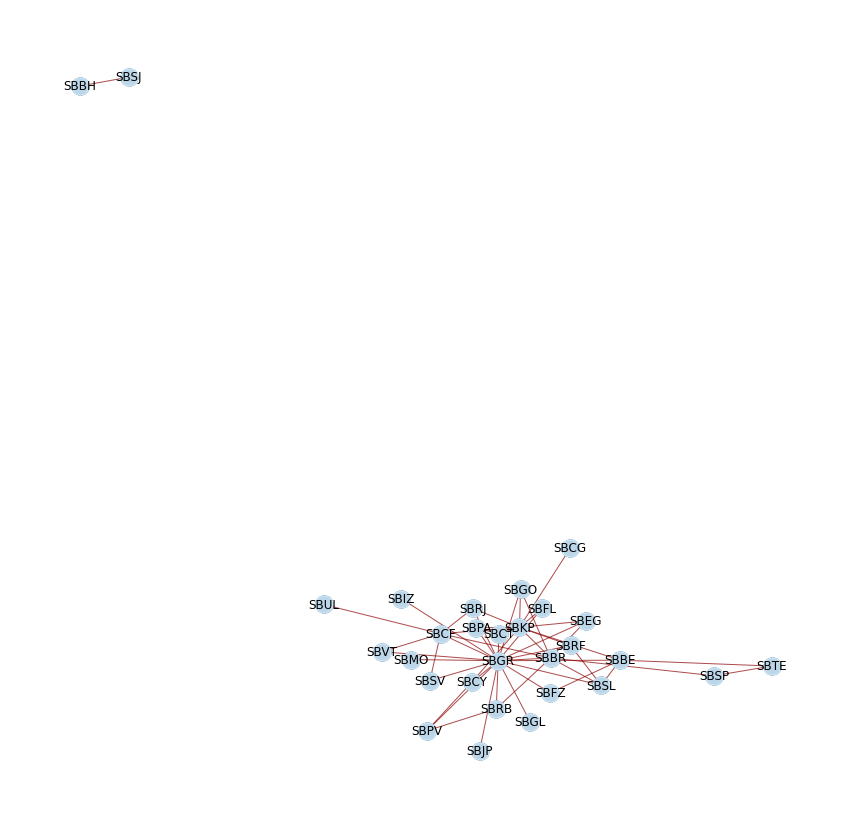

In [745]:
# Visualization of network graph.
Brazilian_flight_network.network_graph()

[('SBGR', 21), ('SBBR', 8), ('SBBE', 5), ('SBRB', 3), ('SBPA', 3), ('SBKP', 12), ('SBGL', 1), ('SBCF', 7), ('SBVT', 2), ('SBSL', 4), ('SBCY', 3), ('SBFL', 2), ('SBRJ', 3), ('SBJP', 1), ('SBPV', 3), ('SBTE', 2), ('SBBH', 1), ('SBGO', 3), ('SBRF', 3), ('SBFZ', 2), ('SBIZ', 1), ('SBEG', 3), ('SBSV', 2), ('SBUL', 1), ('SBCG', 1), ('SBSP', 2), ('SBSJ', 1), ('SBCT', 3), ('SBMO', 1)]


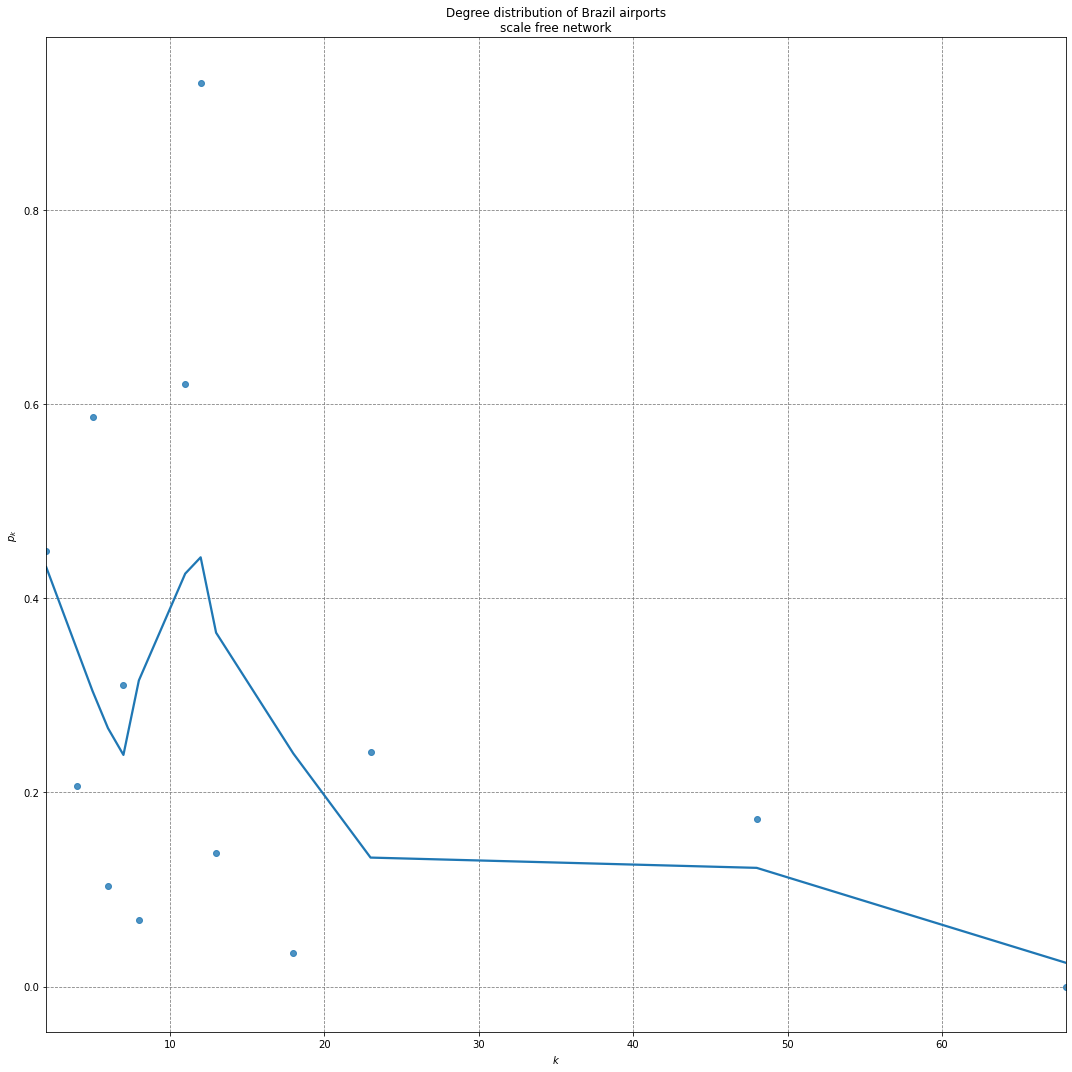

In [763]:
# Calculating degrees and degree distribution.
print(Brazilian_flight_network.graph().degree)

Brazilian_flight_network.degree_destribution()

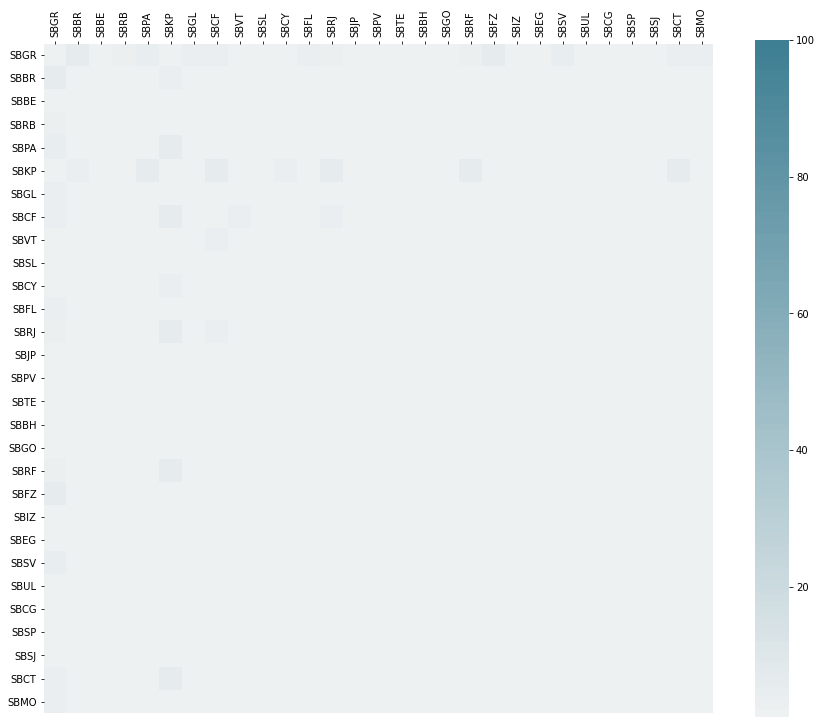

In [746]:
# Adjacency matrix heatmap.
Brazilian_flight_network.adjacency_matrix()

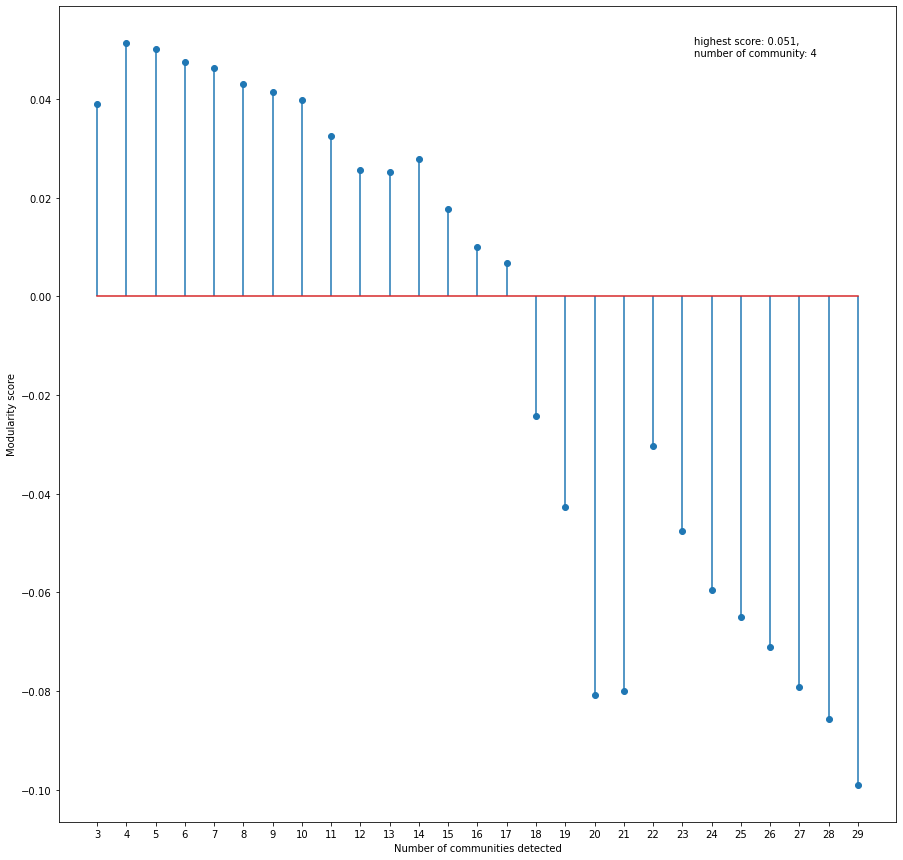

In [747]:
# Modularity measurement.
Brazilian_flight_network.modularity_score()

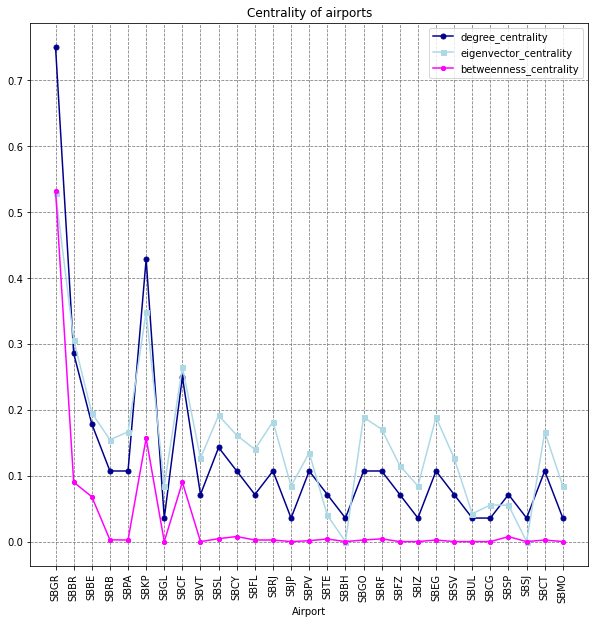

In [748]:
# Centrality measurement.
Brazilian_flight_network.centrality()